In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.models.np.neural_process import NeuralProcess
from activephasemap.utils.settings import initialize_model
from activephasemap.utils.simulators import UVVisExperiment
from apdist.distances import AmplitudePhaseDistance as dist
import glob, json

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [7]:
DATA_DIR = "./"
TOTAL_ITERATIONS = len(glob.glob(DATA_DIR+"data/spectra_*.npy"))
with open('../best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

def load_data_and_models(max_iters):
    design_space_bounds = [(0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0), 
                       (0.0, 11.0),
                       ]

    expt = UVVisExperiment(design_space_bounds, max_iters, DATA_DIR+"/data/")
    expt.generate(use_spline=True)
    gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
    input_dim = expt.dim

    # Load trained GP model for p(z|c)
    train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%max_iters, map_location=device)
    train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%max_iters, map_location=device)
    bounds = expt.bounds.to(device)
    normalized_x = normalize(train_x, bounds).to(train_x)
    gp_model = initialize_model(normalized_x, train_y, gp_model_args, input_dim, N_LATENT, device)
    gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(max_iters), map_location=device)
    gp_model.load_state_dict(gp_state_dict)

    # Load trained NP model for p(y|z)
    np_model = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
    np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(max_iters), map_location=device))

    return expt, gp_model, np_model

In [8]:
def get_accuracy(comps, bounds, time, spectra, gp_model, np_model):
    distances = []
    for i in range(comps.shape[0]):
        comp = comps[i,:].reshape(-1,1)
        c = torch.from_numpy(comp).to(device)

        tt = torch.from_numpy(time).to(device)
        x_target = tt.repeat(comp.shape[0]).view(comp.shape[0], len(time), 1)
        y_true = torch.from_numpy(spectra[i,:]).to(device)

        with torch.no_grad():
            gp_model.eval()
            normalized_x = normalize(c, bounds.to(c))
            posterior = gp_model.posterior(normalized_x)

            mu = []
            for _ in range(250):
                mu_i, _ = np_model.xz_to_y(x_target, posterior.rsample().squeeze(0))
                mu.append(mu_i)

            y_pred = torch.cat(mu).mean(dim=0, keepdim=True).squeeze()
        
        optim_kwargs = {"optim":"DP", "grid_dim":10}
        amplitude, phase = dist(time, y_true.numpy(), y_pred.numpy(), **optim_kwargs)
        distances.append((amplitude + phase))

    return np.asarray(distances).mean()

accuracies = {}
for iters in range(1,TOTAL_ITERATIONS):
    expt, gp_model, np_model = load_data_and_models(iters)
    train_mean_accuracy = get_accuracy(expt.comps, 
                                       expt.bounds, 
                                       expt.t, 
                                       expt.spectra_normalized, 
                                       gp_model, 
                                       np_model
                                       )
    
    next_comps = np.load(DATA_DIR+"/data/comps_%d.npy"%(iters))
    next_spectra = np.load(DATA_DIR+"/data/spectra_%d.npy"%(iters))

    wav = np.load(DATA_DIR+"/data/wav.npy")
    next_time = (wav-min(wav))/(max(wav)-min(wav))

    test_mean_accuracy =  get_accuracy(next_comps, 
                                       expt.bounds, 
                                       next_time, 
                                       next_spectra, 
                                       gp_model, 
                                       np_model
                                       )
    print("Iteration %d : Train error : %2.4f \t Test error : %2.4f"%(iters, train_mean_accuracy, test_mean_accuracy))
    accuracies[iters] = (train_mean_accuracy, test_mean_accuracy)

Loading data from iteration 0 with shapes: (72, 5) (72, 101)


/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iteration 1 : Train error : 0.9533 	 Test error : 1.0613
Loading data from iteration 0 with shapes: (72, 5) (72, 101)
Loading data from iteration 1 with shapes: (87, 5) (87, 101)
Iteration 2 : Train error : 1.0938 	 Test error : 1.1857
Loading data from iteration 0 with shapes: (72, 5) (72, 101)
Loading data from iteration 1 with shapes: (87, 5) (87, 101)
Loading data from iteration 2 with shapes: (86, 5) (86, 101)
Iteration 3 : Train error : 1.0121 	 Test error : 1.0387


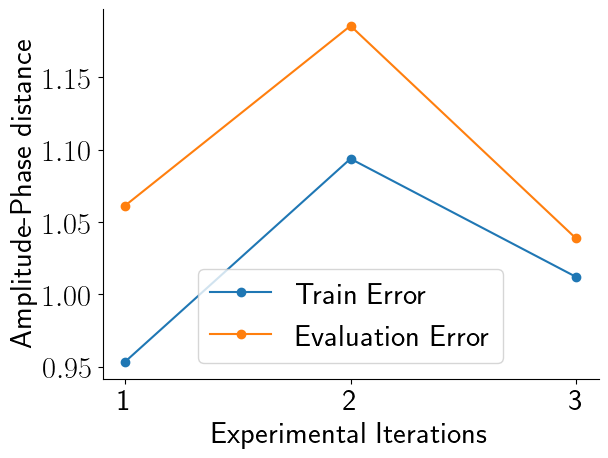

In [9]:
train = np.asarray([y[0] for _,y in accuracies.items()]).squeeze()
test = np.asarray([y[1] for _,y in accuracies.items()]).squeeze()
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    xticks = np.arange(1, TOTAL_ITERATIONS)
    ax.plot(xticks, train,  "-o", label="Train Error")
    ax.plot(xticks, test,  "-o", label="Evaluation Error")
    ax.legend()
    xlabels = ["%d"%x for x in xticks]
    ax.set_xticks(xticks, labels=xlabels)
    ax.set_xlabel("Experimental Iterations")
    ax.set_ylabel("Amplitude-Phase distance")
    plt.show()